## SQLite3 Setup

The main reason why SQL is the defacto standard for storing and retrieving data in modern day, is the fact that it's a lot more operationally efficient when it comes to retrieving and storing data than any general purpose programming language is at operating at from a fundamental design perspective.

**Relational databases are:**
- Performant for I/O (CRUD)
- Atomically resiliant 
- Designed with the sole purpose of organizing and accessing data (highly optimized)

SQLite3 is a very "barebones" database that is great to learn becuase it's supported on just about any platform that supports Python.  It will handle our needs internally quite well, but won't be ideal when it comes to serving an app to the public.  For that we will likely use Postgres which is easy to migrate to.

For the time being, whenver you make a connection using the SQLite `.connect("name.db")`, it will create the resource if it doesn't exist, or will open the database file and use it like a regular SQL database.

I recommend these resources for the basics:

- https://www.datacamp.com/community/tutorials/beginners-guide-to-sqlite
- https://www.sqlitetutorial.net/ (sections 1-3 for now)
- https://www.guru99.com/sqlite-query.html

This is a great GUI based client for building queries which I find helpful in my workflow: 

<img src="https://snipboard.io/m0YHvg.jpg">

https://sqlitebrowser.org/

### The workflow I use:

#### For larger queries
1. Develop SQL queries with Sqlite Browser or from the command line client
1. Copy query into notebook or code

#### For smaller queries
1. Just code them in Python then use `pd.read_sql("sql statement", conn = conn)` _`conn` is the connection to the DB resource._

For the latter, SQL is turned directly into a dataframe.

In [1]:
import pandas as pd, numpy as np
import sqlite3, errno, os
from tqdm import tqdm
from pathlib import Path

### Connect To SQLite3 Database

This will create a database file if one does not exist.

In [2]:
conn = sqlite3.connect("../data/interim/lcd_daily.db")

### Open a single CSV file downloaded from the `../data/external/fetch_historical.sh` file
You should run this script to download the historical data from the LCD repository.

Relative to the repo root directory, the script is in:

`./data/external/fetch_historical.sh`

To use it, just need to `git pull` then:

1. `cd data/external`
1. `chmod +x fetch_historical.sh` to make it executable
Make sure you have permissions to create directories in the `data/external` directory
1. run `./fetch_historical.sh -i [station you want]`

This will create a historical subdirectory and put the station data in a subdirectory by `year/station_id.csv` so if the station is `25507` (homer), it will create the following resources locally:

`data/external/historical/1960/22507.csv`
`data/external/historical/1961/22507.csv`
`data/external/historical/1962/22507.csv`
`data/external/historical/1963/22507.csv`
..etc

You can also use these optional parameters to control the date range:

  - -s start year
  - -e end year (omitting -e will default to current system year from `date` command)

So a full example would be:

```
./fetch_historical -i 22507 -s 1960 -e 2020
```

In [3]:
test_df = pd.read_csv("../data/external/historical/1960/25507.csv", low_memory = False)
# test_df.to_sql("daily", if_exists)

### Check Types

Types are incredibly important.  Here we should deal with any problems with types or bad / missing data before we commit anything to our database.

In [4]:
test_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 123 columns):
STATION                                         int64
DATE                                            object
LATITUDE                                        float64
LONGITUDE                                       float64
ELEVATION                                       float64
NAME                                            object
REPORT_TYPE                                     object
SOURCE                                          int64
HourlyAltimeterSetting                          float64
HourlyDewPointTemperature                       object
HourlyDryBulbTemperature                        float64
HourlyPrecipitation                             float64
HourlyPresentWeatherType                        object
HourlyPressureChange                            float64
HourlyPressureTendency                          float64
HourlyRelativeHumidity                          float64
Hourl

### Map Columns / Rename Variables

Here is the place we should deal with any type of renaming if we see fit.  This dictionary can be changed to reflect any naming convention we want to adopt.  Perhaps it's best to use the data as is but this step is available if we're not happy with the existing names.

#### Mapping convention

```python
name_map = dict(
    existing_column_name  = "new_column_name",
    another_column_in_csv = "new_column_name",
)
```

In [5]:
blank = ""
for col in test_df.columns:
    col = f"'{col}'"
    print(f"{col.ljust(48)}: {col},")

'STATION'                                       : 'STATION',
'DATE'                                          : 'DATE',
'LATITUDE'                                      : 'LATITUDE',
'LONGITUDE'                                     : 'LONGITUDE',
'ELEVATION'                                     : 'ELEVATION',
'NAME'                                          : 'NAME',
'REPORT_TYPE'                                   : 'REPORT_TYPE',
'SOURCE'                                        : 'SOURCE',
'HourlyAltimeterSetting'                        : 'HourlyAltimeterSetting',
'HourlyDewPointTemperature'                     : 'HourlyDewPointTemperature',
'HourlyDryBulbTemperature'                      : 'HourlyDryBulbTemperature',
'HourlyPrecipitation'                           : 'HourlyPrecipitation',
'HourlyPresentWeatherType'                      : 'HourlyPresentWeatherType',
'HourlyPressureChange'                          : 'HourlyPressureChange',
'HourlyPressureTendency'                        : 'H

In [6]:
name_map = {
    'STATION'                                       : 'STATION',
    'DATE'                                          : 'DATE',
    'LATITUDE'                                      : 'LATITUDE',
    'LONGITUDE'                                     : 'LONGITUDE',
    'ELEVATION'                                     : 'ELEVATION',
    'NAME'                                          : 'NAME',
    'REPORT_TYPE'                                   : 'REPORT_TYPE',
    'SOURCE'                                        : 'SOURCE',
    'HourlyAltimeterSetting'                        : 'HourlyAltimeterSetting',
    'HourlyDewPointTemperature'                     : 'HourlyDewPointTemperature',
    'HourlyDryBulbTemperature'                      : 'HourlyDryBulbTemperature',
    'HourlyPrecipitation'                           : 'HourlyPrecipitation',
    'HourlyPresentWeatherType'                      : 'HourlyPresentWeatherType',
    'HourlyPressureChange'                          : 'HourlyPressureChange',
    'HourlyPressureTendency'                        : 'HourlyPressureTendency',
    'HourlyRelativeHumidity'                        : 'HourlyRelativeHumidity',
    'HourlySkyConditions'                           : 'HourlySkyConditions',
    'HourlySeaLevelPressure'                        : 'HourlySeaLevelPressure',
    'HourlyStationPressure'                         : 'HourlyStationPressure',
    'HourlyVisibility'                              : 'HourlyVisibility',
    'HourlyWetBulbTemperature'                      : 'HourlyWetBulbTemperature',
    'HourlyWindDirection'                           : 'HourlyWindDirection',
    'HourlyWindGustSpeed'                           : 'HourlyWindGustSpeed',
    'HourlyWindSpeed'                               : 'HourlyWindSpeed',
    'Sunrise'                                       : 'Sunrise',
    'Sunset'                                        : 'Sunset',
    'DailyAverageDewPointTemperature'               : 'DailyAverageDewPointTemperature',
    'DailyAverageDryBulbTemperature'                : 'DailyAverageDryBulbTemperature',
    'DailyAverageRelativeHumidity'                  : 'DailyAverageRelativeHumidity',
    'DailyAverageSeaLevelPressure'                  : 'DailyAverageSeaLevelPressure',
    'DailyAverageStationPressure'                   : 'DailyAverageStationPressure',
    'DailyAverageWetBulbTemperature'                : 'DailyAverageWetBulbTemperature',
    'DailyAverageWindSpeed'                         : 'DailyAverageWindSpeed',
    'DailyCoolingDegreeDays'                        : 'DailyCoolingDegreeDays',
    'DailyDepartureFromNormalAverageTemperature'    : 'DailyDepartureFromNormalAverageTemperature',
    'DailyHeatingDegreeDays'                        : 'DailyHeatingDegreeDays',
    'DailyMaximumDryBulbTemperature'                : 'DailyMaximumDryBulbTemperature',
    'DailyMinimumDryBulbTemperature'                : 'DailyMinimumDryBulbTemperature',
    'DailyPeakWindDirection'                        : 'DailyPeakWindDirection',
    'DailyPeakWindSpeed'                            : 'DailyPeakWindSpeed',
    'DailyPrecipitation'                            : 'DailyPrecipitation',
    'DailySnowDepth'                                : 'DailySnowDepth',
    'DailySnowfall'                                 : 'DailySnowfall',
    'DailySustainedWindDirection'                   : 'DailySustainedWindDirection',
    'DailySustainedWindSpeed'                       : 'DailySustainedWindSpeed',
    'DailyWeather'                                  : 'DailyWeather',
    'MonthlyAverageRH'                              : 'MonthlyAverageRH',
    'MonthlyDaysWithGT001Precip'                    : 'MonthlyDaysWithGT001Precip',
    'MonthlyDaysWithGT010Precip'                    : 'MonthlyDaysWithGT010Precip',
    'MonthlyDaysWithGT32Temp'                       : 'MonthlyDaysWithGT32Temp',
    'MonthlyDaysWithGT90Temp'                       : 'MonthlyDaysWithGT90Temp',
    'MonthlyDaysWithLT0Temp'                        : 'MonthlyDaysWithLT0Temp',
    'MonthlyDaysWithLT32Temp'                       : 'MonthlyDaysWithLT32Temp',
    'MonthlyDepartureFromNormalAverageTemperature'  : 'MonthlyDepartureFromNormalAverageTemperature',
    'MonthlyDepartureFromNormalCoolingDegreeDays'   : 'MonthlyDepartureFromNormalCoolingDegreeDays',
    'MonthlyDepartureFromNormalHeatingDegreeDays'   : 'MonthlyDepartureFromNormalHeatingDegreeDays',
    'MonthlyDepartureFromNormalMaximumTemperature'  : 'MonthlyDepartureFromNormalMaximumTemperature',
    'MonthlyDepartureFromNormalMinimumTemperature'  : 'MonthlyDepartureFromNormalMinimumTemperature',
    'MonthlyDepartureFromNormalPrecipitation'       : 'MonthlyDepartureFromNormalPrecipitation',
    'MonthlyDewpointTemperature'                    : 'MonthlyDewpointTemperature',
    'MonthlyGreatestPrecip'                         : 'MonthlyGreatestPrecip',
    'MonthlyGreatestPrecipDate'                     : 'MonthlyGreatestPrecipDate',
    'MonthlyGreatestSnowDepth'                      : 'MonthlyGreatestSnowDepth',
    'MonthlyGreatestSnowDepthDate'                  : 'MonthlyGreatestSnowDepthDate',
    'MonthlyGreatestSnowfall'                       : 'MonthlyGreatestSnowfall',
    'MonthlyGreatestSnowfallDate'                   : 'MonthlyGreatestSnowfallDate',
    'MonthlyMaxSeaLevelPressureValue'               : 'MonthlyMaxSeaLevelPressureValue',
    'MonthlyMaxSeaLevelPressureValueDate'           : 'MonthlyMaxSeaLevelPressureValueDate',
    'MonthlyMaxSeaLevelPressureValueTime'           : 'MonthlyMaxSeaLevelPressureValueTime',
    'MonthlyMaximumTemperature'                     : 'MonthlyMaximumTemperature',
    'MonthlyMeanTemperature'                        : 'MonthlyMeanTemperature',
    'MonthlyMinSeaLevelPressureValue'               : 'MonthlyMinSeaLevelPressureValue',
    'MonthlyMinSeaLevelPressureValueDate'           : 'MonthlyMinSeaLevelPressureValueDate',
    'MonthlyMinSeaLevelPressureValueTime'           : 'MonthlyMinSeaLevelPressureValueTime',
    'MonthlyMinimumTemperature'                     : 'MonthlyMinimumTemperature',
    'MonthlySeaLevelPressure'                       : 'MonthlySeaLevelPressure',
    'MonthlyStationPressure'                        : 'MonthlyStationPressure',
    'MonthlyTotalLiquidPrecipitation'               : 'MonthlyTotalLiquidPrecipitation',
    'MonthlyTotalSnowfall'                          : 'MonthlyTotalSnowfall',
    'MonthlyWetBulb'                                : 'MonthlyWetBulb',
    'AWND'                                          : 'AWND',
    'CDSD'                                          : 'CDSD',
    'CLDD'                                          : 'CLDD',
    'DSNW'                                          : 'DSNW',
    'HDSD'                                          : 'HDSD',
    'HTDD'                                          : 'HTDD',
    'NormalsCoolingDegreeDay'                       : 'NormalsCoolingDegreeDay',
    'NormalsHeatingDegreeDay'                       : 'NormalsHeatingDegreeDay',
    'ShortDurationEndDate005'                       : 'ShortDurationEndDate005',
    'ShortDurationEndDate010'                       : 'ShortDurationEndDate010',
    'ShortDurationEndDate015'                       : 'ShortDurationEndDate015',
    'ShortDurationEndDate020'                       : 'ShortDurationEndDate020',
    'ShortDurationEndDate030'                       : 'ShortDurationEndDate030',
    'ShortDurationEndDate045'                       : 'ShortDurationEndDate045',
    'ShortDurationEndDate060'                       : 'ShortDurationEndDate060',
    'ShortDurationEndDate080'                       : 'ShortDurationEndDate080',
    'ShortDurationEndDate100'                       : 'ShortDurationEndDate100',
    'ShortDurationEndDate120'                       : 'ShortDurationEndDate120',
    'ShortDurationEndDate150'                       : 'ShortDurationEndDate150',
    'ShortDurationEndDate180'                       : 'ShortDurationEndDate180',
    'ShortDurationPrecipitationValue005'            : 'ShortDurationPrecipitationValue005',
    'ShortDurationPrecipitationValue010'            : 'ShortDurationPrecipitationValue010',
    'ShortDurationPrecipitationValue015'            : 'ShortDurationPrecipitationValue015',
    'ShortDurationPrecipitationValue020'            : 'ShortDurationPrecipitationValue020',
    'ShortDurationPrecipitationValue030'            : 'ShortDurationPrecipitationValue030',
    'ShortDurationPrecipitationValue045'            : 'ShortDurationPrecipitationValue045',
    'ShortDurationPrecipitationValue060'            : 'ShortDurationPrecipitationValue060',
    'ShortDurationPrecipitationValue080'            : 'ShortDurationPrecipitationValue080',
    'ShortDurationPrecipitationValue100'            : 'ShortDurationPrecipitationValue100',
    'ShortDurationPrecipitationValue120'            : 'ShortDurationPrecipitationValue120',
    'ShortDurationPrecipitationValue150'            : 'ShortDurationPrecipitationValue150',
    'ShortDurationPrecipitationValue180'            : 'ShortDurationPrecipitationValue180',
    'REM'                                           : 'REM',
    'BackupDirection'                               : 'BackupDirection',
    'BackupDistance'                                : 'BackupDistance',
    'BackupDistanceUnit'                            : 'BackupDistanceUnit',
    'BackupElements'                                : 'BackupElements',
    'BackupElevation'                               : 'BackupElevation',
    'BackupEquipment'                               : 'BackupEquipment',
    'BackupLatitude'                                : 'BackupLatitude',
    'BackupLongitude'                               : 'BackupLongitude',
    'BackupName'                                    : 'BackupName',
    'WindEquipmentChangeDate'                       : 'WindEquipmentChangeDate',
}

## Use this to check the data post-rename
## We probably won't need this immediately but once we have this map updated, we can roll it in to the code following these cells
# test_df = test_df.rename(columns = name_map)
# test_df.head()

## Get All CSVs by Station

The reason for this is that as we build a bigger process, any problems we run into, can be contextualized, contained, and thus diagnosed in a way that offers the least amount of cross-over.  If we just processed files by random, it would make data quality checks harder in the future.

In [7]:
station_id = 25507
to_process = []
for path in Path('../data/external/historical/').rglob(f'*{station_id}.csv'):
    to_process.append(str(path.relative_to("./")))

In [8]:
historical = Path("../data/external/historical/")
historical.exists()

True

In [9]:
class LCDio:
    
    historical_path   = "../data/external/historical/"
    sqlite_db         = "../data/interim/lcd_daily.db"
    sqlite_dbh        = False
    station_id        = 25507
    station_csv_files = False
    validate_years    = True   # Check that all years are accounted for given a station_id
    name_map          = False  # If set, will rename columes based on map defined previously 
    
    def __init__(self, **opts):
        
        for attr, value in opts.items():
            if getattr(self, attr):
                setattr(self, attr, value)
        
        path = Path(self.historical_path)
        if not path.exists():
            error_msg = self.historical_path + ". Please update historical_path parameter."
            raise FileNotFoundError(
                errno.ENOENT, os.strerror(errno.ENOENT), error_msg)
        
        # This makes the asesumption historical/YYYY directory naming convention
        if not self.validate_all_years():
            print("Missing years in {self.historical}")
            raise 
            
        ## Connect to database
        self.sqlite_dbh = sqlite3.connect(self.sqlite_db)
        
        self.set_station_csv_files()
        
            
    def validate_all_years(self):
        years = []
        for path in Path(self.historical_path).rglob(f'*{self.station_id}.csv'):
            years.append(int(str(path.relative_to(self.historical_path)).split("/")[0]))
            
        min_year, max_year = min(years), max(years)
        ## Too complex
        # difference = (set(years).difference(set(list(range(min_year, max_year + 1)))))
        if max_year + 1 - min_year == len(years):
            return True
        else:
            return False
    
    def set_station_csv_files(self):
        self.station_csv_files = []
        for path in Path(self.historical_path).rglob(f'*{self.station_id}.csv'):
            self.station_csv_files.append(str(path.relative_to("./")))
            

    def import_station_csv(self):
        for csv_file in tqdm(self.station_csv_files):
            temp_df = pd.read_csv(csv_file, low_memory = False)
            temp_df['DATE'] = pd.to_datetime(temp_df['DATE'])
            
            # Map any columns if available
            if self.name_map:
                temp_df = temp_df.rename(columns = self.name_map)
            
            # Next update I will have it only append records that don't exist yet
            temp_df.to_sql("daily", if_exists = "append", con = self.sqlite_dbh)

### Import Data with `LCDio`

I wrote this class that will be easy to run from Airflow or a simple cron job.  The first part of the job kicks off the scrape to the NOAA repository on the web and transforms the data to CSV.  Finally, all historical data will load all CSVs and   If you want to run this import from outside this notebook / directory, or use the other parameters, simply initialize LCDio with updated parameters:

```python
lcd = LCDio(
    station_id      = [the station],
    historical_path = "../relative/path/to/historical/directory",
    sqlite_db       = "the/path/to/db_file.db",
    name_map        = name_map # update the dictionary map above to map the columns from the original names to our canonnical names if desired
)
```

Depending on HD i/o speed, the import should take roughly 2 minutes per station.  Upon subsequent execution, only new data is pulled and imported to your database.

In [15]:
lcd = LCDio(station_id = 25507)
lcd.import_station_csv()

100%|██████████| 61/61 [01:35<00:00,  1.57s/it]


### Check Out Data From SQLite

This is great reference code you can use to explore the data on your own / in your own notebooks.

In [25]:
homer.columns

Index(['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME',
       'HourlyAltimeterSetting'],
      dtype='object')

In [26]:
con = sqlite3.connect("../data/interim/lcd_daily.db")

sql = """
SELECT 
STATION,
DATE, 
LATITUDE,
LONGITUDE,
ELEVATION,
NAME, 
HourlyAltimeterSetting,
HourlyDewPointTemperature
FROM daily
"""

homer = pd.read_sql(sql, con = conn)
homer

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,HourlyAltimeterSetting,HourlyDewPointTemperature
0,70341025507,2013-01-01 00:53:00,59.642,-151.4908,19.5,"HOMER AIRPORT, AK US",29.36,37
1,70341025507,2013-01-01 01:53:00,59.642,-151.4908,19.5,"HOMER AIRPORT, AK US",29.36,37
2,70341025507,2013-01-01 02:53:00,59.642,-151.4908,19.5,"HOMER AIRPORT, AK US",29.36,37
3,70341025507,2013-01-01 03:53:00,59.642,-151.4908,19.5,"HOMER AIRPORT, AK US",29.34,28
4,70341025507,2013-01-01 04:53:00,59.642,-151.4908,19.5,"HOMER AIRPORT, AK US",29.32,27
...,...,...,...,...,...,...,...,...
520950,70341025507,2004-12-31 21:53:00,59.642,-151.4908,19.5,"HOMER AIRPORT, AK US",30.22,29
520951,70341025507,2004-12-31 22:53:00,59.642,-151.4908,19.5,"HOMER AIRPORT, AK US",30.22,29
520952,70341025507,2004-12-31 23:53:00,59.642,-151.4908,19.5,"HOMER AIRPORT, AK US",30.23,28
520953,70341025507,2004-12-31 23:59:00,59.642,-151.4908,19.5,"HOMER AIRPORT, AK US",None,None


In [30]:
homer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520955 entries, 0 to 520954
Data columns (total 8 columns):
STATION                      520955 non-null int64
DATE                         520955 non-null object
LATITUDE                     520955 non-null float64
LONGITUDE                    520955 non-null float64
ELEVATION                    520955 non-null float64
NAME                         520955 non-null object
HourlyAltimeterSetting       433565 non-null object
HourlyDewPointTemperature    496207 non-null object
dtypes: float64(3), int64(1), object(4)
memory usage: 31.8+ MB


In [12]:
homer['HourlyAltimeterSetting'].value_counts()

29.85     5027
29.91     5024
29.93     4989
29.92     4971
29.95     4966
          ... 
29.78s       1
29.66s       1
29.36s       1
30.16s       1
29.85s       1
Name: HourlyAltimeterSetting, Length: 446, dtype: int64

In [18]:
homer['HourlyAltimeterSetting'].map(lambda n: int(n) if type(n) == float else np.nan)

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
9158   NaN
9159   NaN
9160   NaN
9161   NaN
9162   NaN
Name: HourlyAltimeterSetting, Length: 9163, dtype: float64

In [17]:
homer['HourlyAltimeterSetting'].iloc[0]

'29.36'

In [27]:
to_clean = ["HourlyDewPointTemperature", "HourlyAltimeterSetting"]

homer['HourlyDewPointTemperature'] = homer['HourlyDewPointTemperature'].map(lambda n: float(n.replace("s", "")) if n and len(n) else np.nan)

TypeError: object of type 'float' has no len()

In [29]:
homer['HourlyDewPointTemperature'].astype(float)

ValueError: could not convert string to float: '40s'

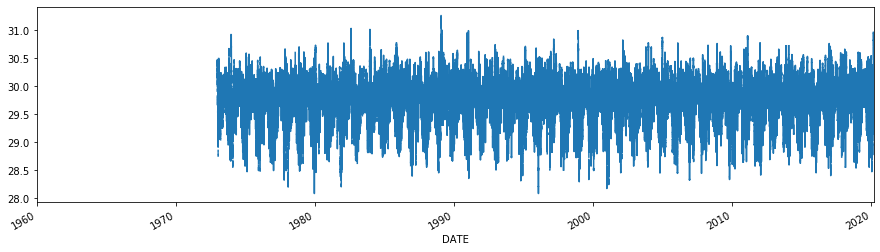

In [23]:
homer['DATE'] = pd.to_datetime(homer['DATE'])
homer.set_index("DATE")['HourlyAltimeterSetting'].plot(figsize = (15, 4))

In [24]:
homer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520955 entries, 0 to 520954
Data columns (total 7 columns):
STATION                   520955 non-null int64
DATE                      520955 non-null datetime64[ns]
LATITUDE                  520955 non-null float64
LONGITUDE                 520955 non-null float64
ELEVATION                 520955 non-null float64
NAME                      520955 non-null object
HourlyAltimeterSetting    433565 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 27.8+ MB


In [8]:
homer['DATE'].min()

'2004-01-01 00:00:00'

In [9]:
homer['DATE'].max()

'2004-12-31 23:59:00'

In [10]:
pd.read_csv("../data/external/historical/1960/25507.csv")

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,...,BackupDirection,BackupDistance,BackupDistanceUnit,BackupElements,BackupElevation,BackupEquipment,BackupLatitude,BackupLongitude,BackupName,WindEquipmentChangeDate
0,99999925507,1960-01-01T00:00:00,59.642,-151.4908,19.5,"HOMER AIRPORT, AK US",SAO,5,NaN,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-09-23
1,99999925507,1960-01-01T01:00:00,59.642,-151.4908,19.5,"HOMER AIRPORT, AK US",SAO,5,NaN,27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-09-23
2,99999925507,1960-01-01T02:00:00,59.642,-151.4908,19.5,"HOMER AIRPORT, AK US",SAO,5,NaN,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-09-23
3,99999925507,1960-01-01T03:00:00,59.642,-151.4908,19.5,"HOMER AIRPORT, AK US",SAO,5,NaN,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-09-23
4,99999925507,1960-01-01T04:00:00,59.642,-151.4908,19.5,"HOMER AIRPORT, AK US",SAO,5,NaN,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-09-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,99999925507,1960-12-31T19:00:00,59.642,-151.4908,19.5,"HOMER AIRPORT, AK US",SAO,5,NaN,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-09-23
8780,99999925507,1960-12-31T20:00:00,59.642,-151.4908,19.5,"HOMER AIRPORT, AK US",SAO,5,NaN,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-09-23
8781,99999925507,1960-12-31T21:00:00,59.642,-151.4908,19.5,"HOMER AIRPORT, AK US",SAO,5,NaN,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-09-23
8782,99999925507,1960-12-31T22:00:00,59.642,-151.4908,19.5,"HOMER AIRPORT, AK US",SAO,5,NaN,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-09-23
